In [1]:
! ls /home/ian.harry/tmp_abi

template_bank  test  train  training_labels.csv


In [1]:
#Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import sem

#Machine learning tool

import keras
import tensorflow 
from keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, GlobalAveragePooling2D, Convolution2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image

from random import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from nnAudio.Spectrogram import CQT1992v2
import efficientnet.tfkeras as efn

2022-05-23 02:39:27.209407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-23 02:39:27.209452: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/abi.abraham/.local/lib/python3.9/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [2]:
# I am using concepts and certain codes used by Mrigendra Agrwal from Kaggle.
#Reference https://www.kaggle.com/code/mrigendraagrawal/tf-g2net-eda-and-starter

In [3]:
#Read in the training labels csv and assign paths
training_labels = pd.read_csv("/home/ian.harry/tmp_abi/training_labels.csv")

path = list(training_labels['id'])
for i in range(len(path)):
    path[i] = '/home/ian.harry/tmp_abi/train/' + path[i][0] +  '/' + path[i][1] +  '/' + path[i][2] +  '/' + path[i] + '.npy'
    



In [8]:
#Function to set a path to call in the data
def path2id(idx,is_train = True):
    path = '/home/ian.harry/tmp_abi'
    if is_train:
        path += '/train/' + idx[0] + '/' + idx[1] + '/' + idx[2] + '/' + idx + '.npy'
    else:
        path += '/train/' + idx[0] + '/' + idx[1] + '/' + idx[2] + '/' + idx + '.npy'
    return path

In [9]:

#function to plot time series of each detector 
def increase_dimension(idx,is_train,transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)): 
    
    waves = np.load(path2id(idx,is_train))
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves)
    image = np.array(image)
    image = np.transpose(image,(1,2,0))
    return image

CQT kernels created, time used = 0.0687 seconds


/home/abi.abraham/.local/lib/python3.9/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


In [10]:
#Dataset Generator 
class Dataset(Sequence):
    
    def __init__(self,idx,y=None,batch_size=32, shuffle= True):
        self.idx = idx
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        if y is not None:
            self.is_train=True
        else:
            self.is_train=False
        self.y = y
        
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
    
    def __getitem__(self,ids):
        batch_ids = self.idx[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
            
        list_x = np.array([increase_dimension(x,self.is_train) for x in batch_ids])
        batch_X = np.stack(list_x)
        
        if self.is_train:
            return batch_X, batch_y
        else:
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))
    
    def debug(self):
        return self.idx

In [11]:
#Reducing the size of dataset 
train_data_size = len(training_labels['id'].values)//50
train_idx = training_labels['id'].values[0:train_data_size]
valid_idx = training_labels['target'].values[0:train_data_size]
test_idx =  training_labels['id'].values[11200:22400]

In [12]:
print(len(train_idx))
print(len(test_idx))

11200
11200


In [13]:
#Spliting the dataset in to train and test sets
x_train, x_test, y_train, y_test = train_test_split(train_idx,valid_idx,test_size=0.05, random_state=None, stratify=valid_idx)

In [14]:
#Applying the dataset generator to train, test and validation sets
train_dataset = Dataset(x_train,y_train)
valid_dataset = Dataset(x_test, y_test)
test_dataset  = Dataset(test_idx)
len(y_train)

10640

In [15]:
#Building the CNN model
model = Sequential([keras.layers.InputLayer(input_shape=(27,128,1)), Convolution2D(3,3,activation='relu',padding='same'), 
                   efn.EfficientNetB0(include_top=False,input_shape=(),weights='imagenet'), 
                   GlobalAveragePooling2D(),
                   #GlobalMaxPooling2D,
                   Dense(256,activation='relu'),
                   Dense(128,activation='relu'),
                   Dense(64,activation='relu'), 
                   Dense(32,activation='relu'), 
                   Dense(16,activation='relu'),
                   Dense(8,activation='relu'),  
                   Dense(4,activation='relu'),  
                   Dense(1,activation='sigmoid')])

model.summary()
model.compile(optimizer= Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 27, 128, 3)        30        
                                                                 
 efficientnet-b0 (Functional  (None, None, None, 1280)  4049564  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_8 (Dense)             (None, 256)               327936    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)               

In [16]:
#Training the model
model.fit(train_dataset, validation_data=valid_dataset, use_multiprocessing=True,
          epochs = 5)

Epoch 1/5
333/333 [==============================] - 673s 2s/step - loss: 0.5728 - accuracy: 0.6878 - val_loss: 0.7272 - val_accuracy: 0.5161
Epoch 2/5
333/333 [==============================] - 605s 2s/step - loss: 0.4977 - accuracy: 0.7492 - val_loss: 0.6552 - val_accuracy: 0.6250
Epoch 3/5
333/333 [==============================] - 611s 2s/step - loss: 0.4786 - accuracy: 0.7590 - val_loss: 0.5098 - val_accuracy: 0.7482
Epoch 4/5
333/333 [==============================] - 605s 2s/step - loss: 0.4636 - accuracy: 0.7753 - val_loss: 0.5260 - val_accuracy: 0.7339
Epoch 5/5
333/333 [==============================] - 601s 2s/step - loss: 0.4388 - accuracy: 0.7940 - val_loss: 0.5808 - val_accuracy: 0.6429


In [17]:
model.save('Project/Model')

2022-05-19 16:17:02.289427: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Project/Model/assets


In [5]:
loaded_model = keras.models.load_model('Project/Model')

2022-05-23 02:55:49.732858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-23 02:55:49.732928: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-23 02:55:49.732982: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ldas-pcdev14): /proc/driver/nvidia/version does not exist
2022-05-23 02:55:49.733571: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
df = pd.DataFrame(list()) 
df.to_csv('predsv3.csv')
preds = pd.read_csv('predsv3.csv')

In [15]:
#Model prediciting the using the test sets
model_pred = loaded_model.predict(test_dataset, use_multiprocessing=True,verbose=1)
model_pred = model_pred.reshape(-1)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


350/350 [==============================] - 924s 3s/step


In [22]:
print(len(training_labels))
print(len(train_idx))
print(len(model_pred))

560000
11200
11200


In [23]:
train_data_size2 = len(y_train)
test_idx2 = training_labels['id'].values[11200:22400]

targets_s = training_labels['target']
tar_len = (len(targets_s)//50) 
targets = training_labels['target'].values[11200:22400]
print(len(targets))

11200


In [24]:
print(model_pred)
print(len(model_pred))

[0.96508336 0.95668286 0.4818788  ... 0.6210368  0.7584832  0.99580324]
11200


In [33]:
model_target = np.array(model_pred)
model_target[:,] = model_target[:,]>0.64# setting threshold to create a binary classification
model_targets = model_target.astype(int)
print(model_targets)
print(len(targets)) 
    

[1 1 0 ... 0 1 1]
11200


In [34]:
#To find the best threshold
threshs = np.linspace(0,1,10000)

max_icv = 0

for th in threshs:

    icv = preds['Model Predictions'] > th
    curr_th = sum(icv == preds['Actual Targets']) / len(preds)
    if curr_th > max_icv:
        max_icv = curr_th
        max_th = th
print(max_icv, max_th)

0.7548214285714285 0.718971897189719


In [35]:
#Converting the model predicition to 1 and 0s considering the threshold
target_frac = []
mod_tar = list(model_targets)
act_tar = list(targets)

for i in range(len(mod_tar)):
    if mod_tar[i] == act_tar[i]:
        target_frac.append(1)
    else: 
        target_frac.append(0)

In [30]:
predsv3 = pd.DataFrame({'id':test_idx2,'Model Predictions':model_pred, 
                      'Model Targets':model_targets,
                      'Actual Targets' : targets,
                      'Classified Targets': target_frac})

predsv3.to_csv('predsv3.csv',index = False)

In [31]:
preds.head(5)

,id,Model Predictions,Model Targets,Actual Targets,Classified Targets
0,0512c12234,0.965083,1,1,1
1,0512c43788,0.956683,1,1,1
2,0512f94477,0.481879,0,1,0
3,051303dc5a,0.388922,0,0,1
4,051351f27f,0.462480,0,1,0


In [36]:
num_ones = np.count_nonzero(target_frac)
acc_score = (num_ones/len(target_frac))*100
error_score = (100-acc_score)
print('Classfied Correctly: ', acc_score, 'Classfied Incorrectly: ', error_score)


Classfied Correctly:  73.25892857142857 Classfied Incorrectly:  26.74107142857143


In [37]:
cm = confusion_matrix(act_tar,mod_tar)

TN, FP, FN, TP = confusion_matrix(act_tar,mod_tar).ravel()

print('True Positive(TP) = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN) = ', TN)
print('False Negative(FN) = ', FN)

accuracy = (TP + TN)/(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP) =  4095
False Positive(FP) =  1526
True Negative(TN) =  4110
False Negative(FN) =  1469
Accuracy of the binary classification = 0.733


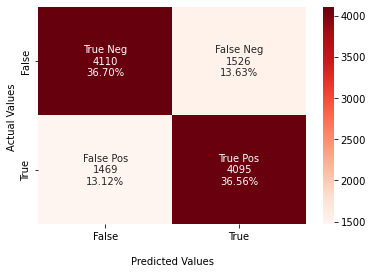

In [38]:
group_names = ['True Neg','False Neg','False Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

#ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
#plt.show()
cm_CNN_of = plt.gcf()

In [39]:
cm_CNN_of.savefig("cm_CNN_of.pdf",format="pdf", bbox_inches ='tight')